In [10]:
import numpy as np
import heapq as hq
import matplotlib.pyplot as plt

In [5]:
class Particle(object):
    def __init__(self,position,velocity,r=0.01,m=1,priority=1):
        self.position = position
        self.velocity = velocity
        self.radius = r
        self.mass = m
        self.priority = priority
    def collisionWall(self,wall):
        self.velocity  = self.velocity - 2* np.dot(self.velocity,wall.normalVec())* wall.normalVec()
            
    def collisionParticle(self,other):
        centralVec = (other.position - self.position) / np.sqrt(np.sum((other.position-self.position)**2))
        transferMomentum = -2*self.mass*other.mass/(self.mass+other.mass) * np.dot((self.velocity-other.velocity), \
                                                                                        centralVec) * centralVec
        self.velocity = self.velocity + transferMomentum / self.mass
        other.velocity = other.velocity - transferMomentum / other.mass
        
    def update(self,dT):
        self.position = self.position + self.velocity * dT
        
    def __lt__(self,other):
        return self.priority < other.priority
    
    def __gt__(self,other):
        return self.priority >= other.priority

class Box(object):
    def __init__(self,width,length):
        self.width = width
        self.length = length
        wall1 = wall((0,0),(0,self.width))
        wall2 = wall((0,self.width),(self.length,self.width))
        wall3 = wall((self.length,self.width),(self.length,0))
        wall4 = wall((self.length,0),(0,0))
        self.walls = [wall1,wall2,wall3,wall4]

class wall(object):
    def __init__(self,endPoint1,endPoint2,priority=0):
        endPoint1 = np.array(endPoint1)
        endPoint2 = np.array(endPoint2)
        self.endP1 = endPoint1
        self.endP2 = endPoint2
        v = self.endP1 - self.endP2 
        self.vector = v/np.sqrt(np.sum(v**2))
        self.priority = priority
    def normalVec(self): # normal vector with a normalized norm
        boxVec = np.array([0,0,-1])
        return np.cross(self.vector,boxVec)[:-1] # for we consider 2d case.
    
    def __lt__(self,other):
        return self.priority < other.priority
    
    def __gt__(self,other):
        return self.priority >= other.priority
    
class EventQuene(object):
    def __init__(self,particles,box):
        self.particles = particles
        self.box = box
        initCollisionEvent = []
        for i,p1 in enumerate(particles):
            for j,p2 in enumerate(particles[i+1:]):
                initCollisionEvent.append((ParticleCollisionTime(p1,p2),p1,p2))
        
            for k,wall in enumerate(box.walls):
                initCollisionEvent.append((WallCollisionTime(p1,wall),p1,wall))
        hq.heapify(initCollisionEvent)
        self.Quene = initCollisionEvent
    def remove(self,ele):
        for t,p1,p2 in self.Quene[:]:
            if p1 == ele or p2 == ele:
                self.Quene.remove((t,p1,p2))
        hq.heapify(self.Quene)
        
    def add(self,ele,time=0):
        self.remove(ele)
        for p in self.particles:
            if p != ele:
                hq.heappush(self.Quene,(ParticleCollisionTime(p1,p,time),p1,p))
        for w in box.walls:
            hq.heappush(self.Quene,(WallCollisionTime(p1,w,time),p1,w))
            
def ParticleCollisionTime(p1,p2,CurrentTime=0,bigNum=1):
    pseudoTs =calculateCollisionTime(p1,p2) # two solutions
    if any(t.imag !=0 for t in pseudoTs): # two particles will not collide with each other
        T = bigNum + CurrentTime
        return T
    else:
        T = min(pseudoTs,key= lambda x: x.real).real + CurrentTime
    return T

def calculateCollisionTime(p1,p2):
    a = np.dot((p1.velocity - p2.velocity),(p1.velocity-p2.velocity))
    b = -2*np.dot((p1.position-p2.position),(p1.velocity-p2.velocity))
    c = complex(np.dot((p1.position-p2.position),(p1.position-p2.position)) - (p1.radius+p2.radius)**2)
    
    sol1 = complex((-1*b+(b**2-4*a*c)**(1/2))/(2*a))
    
    sol2 = complex((-1*b-(b**2-4*a*c)**(1/2))/(2*a))
    return [sol1,sol2]

def WallCollisionTime(p1,wall,CurrentTime=0,bigNum=1): # use constrain to do.
    constrain = []
    for i in range(2):
        if wall.endP1[i] == wall.endP2[i]:
            constrain.append((i,wall.endP1[i]))
    t = (wall.endP1[i] - p1.position[i]) / p1.velocity[i]
    if t <0 or OutOfBoundary(p1,wall,t,i):
        return bigNum + CurrentTime
    else:
        return t + CurrentTime

def OutOfBoundary(p,wall,t,i):  
    expectPosition = p.position[(i+1)%2] + p.velocity[(i+1)%2] * t
    if expectPosition > max([EndP[(i+1)%2] for EndP in [wall.endP1,wall.endP2]]) or \
                            expectPosition < min([EndP[(i+1)%2] for EndP in [wall.endP1,wall.endP2]]):
            return True
    return False
    

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in cdouble_scalars


(array([ 2.,  0.,  3.,  2.,  4.,  7.,  5.,  4.,  5.,  8.,  8.,  9.,  7.,
        14.,  6.,  3.,  7.,  3.,  2.,  1.]),
 array([ 0.90998628,  1.52373489,  2.1374835 ,  2.7512321 ,  3.36498071,
         3.97872932,  4.59247793,  5.20622653,  5.81997514,  6.43372375,
         7.04747236,  7.66122097,  8.27496957,  8.88871818,  9.50246679,
        10.1162154 , 10.72996401, 11.34371261, 11.95746122, 12.57120983,
        13.18495844]),
 <a list of 20 Patch objects>)

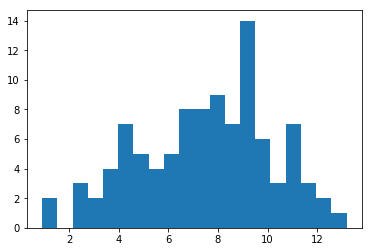

In [16]:
radius = 0.01
NumParticles = 100
NumCollision = 500
length = 1
width = 1
bigNum = min([length,width]) / radius * 100
particles = [Particle(np.random.rand(2),10*np.random.rand(2),r=radius) for _ in range(NumParticles)]
box = Box(length,width)
eventq  = EventQuene(particles,box)

done = False
currentT = 0
totalCollisionTimes = 0
while not done:
    nextT,p1,x = hq.heappop(eventq.Quene)
    deltaT = nextT - currentT
    for p in particles:
        p.update(deltaT)
    if type(x) == Particle:  # if collide with another particle
        p1.collisionParticle(x)
        eventq.remove(x)
        eventq.remove(p1)
        eventq.add(x,time=nextT)
        eventq.add(p1)
    elif type(x) == wall:  # if collide against wall
        p1.collisionWall(x)
        eventq.remove(p1)
        eventq.add(p1,time=nextT)
        
    currentT = nextT
    totalCollisionTimes += 1 
    if totalCollisionTimes == NumCollision:
        done = True
plt.hist([np.dot(p.velocity,p.velocity)**(1/2) for p in particles],bins=20)

1.0


0
